In [1]:
#cell-width control
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Imports

In [2]:
#packages
import numpy
import tensorflow as tf
from tensorflow.core.example import example_pb2

#utils
import os
import random
import pickle
import struct
import time
from generators import *

#keras
import keras
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Model, Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Concatenate, Dot, Embedding, LSTM, Conv1D, MaxPooling1D, Input, Lambda
    #callbacks
from keras.callbacks import TensorBoard, ModelCheckpoint, Callback


Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels

# CPU usage

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Global parameters

In [5]:
# Embedding
max_features = 400000
maxlen_text = 400
maxlen_summ = 80
embedding_size = 100 #128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 32
epochs = 5

In [6]:
#bookkeeping
thresholds = [0.1,0.3,0.5, 0.6, 0.7, 0.75, 0.8, 0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89, 0.9, 0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98, 0.99,0.995,0.999]

stats = {}

In [7]:
use_multiprocessing = True
workers = 4
shuffle = False

#model_path_prefix = '/home/donald/documents/MT/implementation-and-experiments/'
model_path_prefix = '/home/oala/Documents/MT/implementation-experiments/'
#data_path_prefix = '/mnt/disks/500gb/experimental-data-mini/experimental-data-mini/'
data_path_prefix = '/media/oala/4TB/experimental-data/'

ow_on_pseudorandom = ['ow_on_pseudorandom',model_path_prefix + 'exciting-crazy/experiments/ow-on-pseudorandom/1/best.h5']
ow_on_generator = ['ow_on_generator',model_path_prefix + 'exciting-crazy/experiments/ow-on-generator/1/best.h5']
ow_on_uniform = ['ow_on_uniform',model_path_prefix + 'exciting-crazy/experiments/ow-on-uniform/1/best.h5']
tw_on_pseudorandom = ['tw_on_pseudorandom',model_path_prefix + 'exciting-crazy/experiments/tw-on-pseudorandom/1/best.h5']
tw_on_generator = ['tw_on_generator',model_path_prefix + 'exciting-crazy/experiments/tw-on-generator/1/best.h5']
tw_on_uniform = ['tw_on_uniform',model_path_prefix + 'exciting-crazy/experiments/tw-on-uniform/1/best.h5']

model_paths = [tw_on_pseudorandom, tw_on_generator, tw_on_uniform, ow_on_pseudorandom, ow_on_generator, ow_on_uniform]

In [8]:
#get preprocessing data
#processing_dir = '/mnt/disks/500gb/stats-and-meta-data/400000/'
processing_dir = '/media/oala/4TB/experimental-data/stats-and-meta-data/400000/'
with open(processing_dir+'tokenizer.pickle', 'rb') as handle: tokenizer = pickle.load(handle)
embedding_matrix = numpy.load(processing_dir+'embedding_matrix.npy')
#stats
maxi = numpy.load(processing_dir+'training-stats-all/maxi.npy')
mini = numpy.load(processing_dir+'training-stats-all/mini.npy')
sample_info = (numpy.random.uniform, mini,maxi)


#pre-init dict
for model_path in model_paths:
        model_name = model_path[0]
        stats[model_name] = {}
        for threshold in thresholds:
            stats[model_name][threshold] = {}
                


for threshold in thresholds:
    print('threshold:\t'+str(threshold))
    for model_path in model_paths:
        model_name = model_path[0]
        model = load_model(model_path[1])

        print('###'+model_name+'###')

        if model_name[0:2] == 'tw':
            #eval on clean test
            data_dir = data_path_prefix + 'evaluation-data/test-onlyclean/only-clean/'
            with open(data_dir+'partition.pickle', 'rb') as handle: partition = pickle.load(handle)
            with open(data_dir+'labels.pickle', 'rb') as handle: labels = pickle.load(handle)
            #batch generator parameters
            params = {'dim': [(maxlen_text,embedding_size),(maxlen_summ,embedding_size)],
                      'batch_size': batch_size,
                      'shuffle': shuffle,
                     'tokenizer':tokenizer,
                     'embedding_matrix':embedding_matrix,
                     'maxlen_text':maxlen_text,
                     'maxlen_summ':maxlen_summ,
                     'data_dir':data_dir,
                     'sample_info':sample_info}
            #generators
            test_generator = ContAllGenerator(partition['test'], labels, **params)
            # Train model on dataset
            #out = model.evaluate_generator(generator=test_generator,
                                #use_multiprocessing=use_multiprocessing,
                                #workers=workers)
            out = [999,0]
            
            preds = model.predict_generator(generator=test_generator,
                                use_multiprocessing=use_multiprocessing,
                                workers=workers)
            preds[preds < threshold] = 0
            preds[preds != 0] = 1
            out[1] = numpy.mean(preds)
            
            
            #stats[model_name] = {threshold:{'on_clean':out[1]}}
            stats[model_name][threshold]['on_clean'] = out[1]
            print('on 100% clean\t'+'loss:\t'+str(out[0])+'\tacc:\t'+str(out[1]))

            #eval on pseudorandom-noise
            data_dir = data_path_prefix + 'evaluation-data/test-onlynoise/pseudorandom-dist/only-noise/'
            with open(data_dir+'partition.pickle', 'rb') as handle: partition = pickle.load(handle)
            with open(data_dir+'labels.pickle', 'rb') as handle: labels = pickle.load(handle)
            #batch generator parameters
            params = {'dim': [(maxlen_text,embedding_size),(maxlen_summ,embedding_size)],
                      'batch_size': batch_size,
                      'shuffle': shuffle,
                     'tokenizer':tokenizer,
                     'embedding_matrix':embedding_matrix,
                     'maxlen_text':maxlen_text,
                     'maxlen_summ':maxlen_summ,
                     'data_dir':data_dir,
                     'sample_info':sample_info}
            #generators
            test_generator = ContAllGenerator(partition['test'], labels, **params)
            # Train model on dataset
            #out = model.evaluate_generator(generator=test_generator,
                                #use_multiprocessing=use_multiprocessing,
                                #workers=workers)
            
            out = [999,0]
            
            preds = model.predict_generator(generator=test_generator,
                                use_multiprocessing=use_multiprocessing,
                                workers=workers)
            preds[preds < threshold] = 0
            preds[preds != 0] = 1
            out[1] = 1 - numpy.mean(preds)
            
            stats[model_name][threshold]['on_pseudo'] = out[1]
            print('on 100% pseudo\t'+'loss:\t'+str(out[0])+'\tacc:\t'+str(out[1]))

            #eval on generator noise
            data_dir = data_path_prefix + 'evaluation-data/test-onlynoise/generator-dist/only-noise/'
            with open(data_dir+'partition.pickle', 'rb') as handle: partition = pickle.load(handle)
            with open(data_dir+'labels.pickle', 'rb') as handle: labels = pickle.load(handle)
            #batch generator parameters
            params = {'dim': [(maxlen_text,embedding_size),(maxlen_summ,embedding_size)],
                      'batch_size': batch_size,
                      'shuffle': shuffle,
                     'tokenizer':tokenizer,
                     'embedding_matrix':embedding_matrix,
                     'maxlen_text':maxlen_text,
                     'maxlen_summ':maxlen_summ,
                     'data_dir':data_dir,
                     'sample_info':sample_info}
            #generators
            test_generator = ContAllGenerator(partition['test'], labels, **params)
            # Train model on dataset
            #out = model.evaluate_generator(generator=test_generator,
                                #use_multiprocessing=use_multiprocessing,
                                #workers=workers)
            out = [999,0]
            
            preds = model.predict_generator(generator=test_generator,
                                use_multiprocessing=use_multiprocessing,
                                workers=workers)
            preds[preds < threshold] = 0
            preds[preds != 0] = 1
            out[1] = 1 - numpy.mean(preds)
            
            stats[model_name][threshold]['on_generator'] = out[1]
            print('on 100% gen\t'+'loss:\t'+str(out[0])+'\tacc:\t'+str(out[1]))

            #eval on clean test
            data_dir = data_path_prefix + 'evaluation-data/test-onlynoise/pseudorandom-dist/only-noise/'
            with open(data_dir+'partition.pickle', 'rb') as handle: partition = pickle.load(handle)
            with open(data_dir+'labels.pickle', 'rb') as handle: labels = pickle.load(handle)
            #batch generator parameters
            params = {'dim': [(maxlen_text,embedding_size),(maxlen_summ,embedding_size)],
                      'batch_size': batch_size,
                      'shuffle': shuffle,
                     'tokenizer':tokenizer,
                     'embedding_matrix':embedding_matrix,
                     'maxlen_text':maxlen_text,
                     'maxlen_summ':maxlen_summ,
                     'data_dir':data_dir,
                     'sample_info':sample_info}
            #generators
            test_generator = TwoQuartGenerator(partition['test'], labels, **params)
            # Train model on dataset
            #out = model.evaluate_generator(generator=test_generator,
                                #use_multiprocessing=use_multiprocessing,
                                #workers=workers)
            out = [999,0]
            
            preds = model.predict_generator(generator=test_generator,
                                use_multiprocessing=use_multiprocessing,
                                workers=workers)
            preds[preds < threshold] = 0
            preds[preds != 0] = 1
            out[1] = 1 - numpy.mean(preds)
            
            stats[model_name][threshold]['on_uniform'] = out[1]
            print('on 100% uni\t'+'loss:\t'+str(out[0])+'\tacc:\t'+str(out[1]))
        elif model_name[0:2] == 'ow':
            #eval on clean test
            data_dir = data_path_prefix + 'evaluation-data/test-onlyclean/only-clean/'
            with open(data_dir+'partition.pickle', 'rb') as handle: partition = pickle.load(handle)
            with open(data_dir+'labels.pickle', 'rb') as handle: labels = pickle.load(handle)
            #batch generator parameters
            params = {'dim': [(maxlen_text,embedding_size),(maxlen_summ,embedding_size)],
                      'batch_size': batch_size,
                      'shuffle': shuffle,
                     'tokenizer':tokenizer,
                     'embedding_matrix':embedding_matrix,
                     'maxlen_text':maxlen_text,
                     'maxlen_summ':maxlen_summ,
                     'data_dir':data_dir,
                     'sample_info':sample_info}
            #generators
            test_generator = ContAllGenerator_ow(partition['test'], labels, **params)
            # Train model on dataset
            #out = model.evaluate_generator(generator=test_generator,
                                #use_multiprocessing=use_multiprocessing,
                                #workers=workers)
            out = [999,0]
            
            preds = model.predict_generator(generator=test_generator,
                                use_multiprocessing=use_multiprocessing,
                                workers=workers)
            preds[preds < threshold] = 0
            preds[preds != 0] = 1
            out[1] = numpy.mean(preds)
            
            #stats[model_name] = {threshold:{'on_clean':out[1]}}
            stats[model_name][threshold]['on_clean'] = out[1]
            print('on 100% clean\t'+'loss:\t'+str(out[0])+'\tacc:\t'+str(out[1]))

            #eval on pseudorandom-noise
            data_dir = data_path_prefix + 'evaluation-data/test-onlynoise/pseudorandom-dist/only-noise/'
            with open(data_dir+'partition.pickle', 'rb') as handle: partition = pickle.load(handle)
            with open(data_dir+'labels.pickle', 'rb') as handle: labels = pickle.load(handle)
            #batch generator parameters
            params = {'dim': [(maxlen_text,embedding_size),(maxlen_summ,embedding_size)],
                      'batch_size': batch_size,
                      'shuffle': shuffle,
                     'tokenizer':tokenizer,
                     'embedding_matrix':embedding_matrix,
                     'maxlen_text':maxlen_text,
                     'maxlen_summ':maxlen_summ,
                     'data_dir':data_dir,
                     'sample_info':sample_info}
            #generators
            test_generator = ContAllGenerator_ow(partition['test'], labels, **params)
            # Train model on dataset
            #out = model.evaluate_generator(generator=test_generator,
                                #use_multiprocessing=use_multiprocessing,
                                #workers=workers)
            out = [999,0]
            
            preds = model.predict_generator(generator=test_generator,
                                use_multiprocessing=use_multiprocessing,
                                workers=workers)
            preds[preds < threshold] = 0
            preds[preds != 0] = 1
            out[1] = 1 - numpy.mean(preds)
            
            stats[model_name][threshold]['on_pseudo'] = out[1]
            print('on 100% pseudo\t'+'loss:\t'+str(out[0])+'\tacc:\t'+str(out[1]))

            #eval on generator noise
            data_dir = data_path_prefix + 'evaluation-data/test-onlynoise/generator-dist/only-noise/'
            with open(data_dir+'partition.pickle', 'rb') as handle: partition = pickle.load(handle)
            with open(data_dir+'labels.pickle', 'rb') as handle: labels = pickle.load(handle)
            #batch generator parameters
            params = {'dim': [(maxlen_text,embedding_size),(maxlen_summ,embedding_size)],
                      'batch_size': batch_size,
                      'shuffle': shuffle,
                     'tokenizer':tokenizer,
                     'embedding_matrix':embedding_matrix,
                     'maxlen_text':maxlen_text,
                     'maxlen_summ':maxlen_summ,
                     'data_dir':data_dir,
                     'sample_info':sample_info}
            #generators
            test_generator = ContAllGenerator_ow(partition['test'], labels, **params)
            # Train model on dataset
            #out = model.evaluate_generator(generator=test_generator,
                                #use_multiprocessing=use_multiprocessing,
                                #workers=workers)
            out = [999,0]
            
            preds = model.predict_generator(generator=test_generator,
                                use_multiprocessing=use_multiprocessing,
                                workers=workers)
            preds[preds < threshold] = 0
            preds[preds != 0] = 1
            out[1] = 1 - numpy.mean(preds)
            
            stats[model_name][threshold]['on_generator'] = out[1]
            print('on 100% gen\t'+'loss:\t'+str(out[0])+'\tacc:\t'+str(out[1]))

            #eval on uniform noise
            data_dir = data_path_prefix + 'evaluation-data/test-onlynoise/pseudorandom-dist/only-noise/'
            with open(data_dir+'partition.pickle', 'rb') as handle: partition = pickle.load(handle)
            with open(data_dir+'labels.pickle', 'rb') as handle: labels = pickle.load(handle)
            #batch generator parameters
            params = {'dim': [(maxlen_text,embedding_size),(maxlen_summ,embedding_size)],
                      'batch_size': batch_size,
                      'shuffle': shuffle,
                     'tokenizer':tokenizer,
                     'embedding_matrix':embedding_matrix,
                     'maxlen_text':maxlen_text,
                     'maxlen_summ':maxlen_summ,
                     'data_dir':data_dir,
                     'sample_info':sample_info}
            #generators
            test_generator = TwoQuartGenerator_ow(partition['test'], labels, **params)
            # Train model on dataset
            #out = model.evaluate_generator(generator=test_generator,
                                #use_multiprocessing=use_multiprocessing,
                                #workers=workers)
            out = [999,0]
            
            preds = model.predict_generator(generator=test_generator,
                                use_multiprocessing=use_multiprocessing,
                                workers=workers)
            preds[preds < threshold] = 0
            preds[preds != 0] = 1
            out[1] = 1 - numpy.mean(preds)
            
            stats[model_name][threshold]['on_uniform'] = out[1]
            print('on 100% uni\t'+'loss:\t'+str(out[0])+'\tacc:\t'+str(out[1]))
        else:
            print('wrong model')
    

threshold:	0.1
###tw_on_pseudorandom###
on 100% clean	loss:	999	acc:	0.98946726
on 100% pseudo	loss:	999	acc:	0.6665215790271759
on 100% gen	loss:	999	acc:	0.1353875994682312
on 100% uni	loss:	999	acc:	0.9892061278223991
###tw_on_generator###
on 100% clean	loss:	999	acc:	0.9800662
on 100% pseudo	loss:	999	acc:	0.2252785563468933
on 100% gen	loss:	999	acc:	0.6286661922931671
on 100% uni	loss:	999	acc:	0.045264601707458496
###tw_on_uniform###
on 100% clean	loss:	999	acc:	1.0
on 100% pseudo	loss:	999	acc:	0.0
on 100% gen	loss:	999	acc:	0.0
on 100% uni	loss:	999	acc:	1.0
###ow_on_pseudorandom###
on 100% clean	loss:	999	acc:	0.9941678
on 100% pseudo	loss:	999	acc:	0.542827308177948
on 100% gen	loss:	999	acc:	0.13591128587722778
on 100% uni	loss:	999	acc:	1.0
###ow_on_generator###
on 100% clean	loss:	999	acc:	0.97527856
on 100% pseudo	loss:	999	acc:	0.22762882709503174
on 100% gen	loss:	999	acc:	0.6428945660591125
on 100% uni	loss:	999	acc:	0.00278550386428833
###ow_on_uniform###
on 100% cle

In [9]:
print(stats)

{'tw_on_pseudorandom': {0.1: {'on_clean': 0.98946726, 'on_pseudo': 0.6665215790271759, 'on_generator': 0.1353875994682312, 'on_uniform': 0.9892061278223991}, 0.3: {'on_clean': 0.96805364, 'on_pseudo': 0.7550487518310547, 'on_generator': 0.2517458200454712, 'on_uniform': 1.0}, 0.5: {'on_clean': 0.94246167, 'on_pseudo': 0.8044916391372681, 'on_generator': 0.3447974920272827, 'on_uniform': 0.9996518105908763}, 0.6: {'on_clean': 0.92583567, 'on_pseudo': 0.827907383441925, 'on_generator': 0.3997032046318054, 'on_uniform': 1.0}, 0.7: {'on_clean': 0.9045961, 'on_pseudo': 0.8512360751628876, 'on_generator': 0.45975905656814575, 'on_uniform': 1.0}, 0.75: {'on_clean': 0.8904944, 'on_pseudo': 0.8634227067232132, 'on_generator': 0.49773043394088745, 'on_uniform': 1.0}, 0.8: {'on_clean': 0.87299794, 'on_pseudo': 0.8783077970147133, 'on_generator': 0.5467004179954529, 'on_uniform': 1.0}, 0.81: {'on_clean': 0.8680362, 'on_pseudo': 0.8821378797292709, 'on_generator': 0.5553421676158905, 'on_uniform': 

In [10]:
import pickle
#with open('stats-4.pickle', 'wb') as handle: pickle.dump(stats, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('stats-2.pickle', 'rb') as handle: stats = pickle.load(handle)

In [11]:
import matplotlib.pyplot as plt

def get_f1(clean_data, pseudo_data, generator_data, uniform_data):
    tpr_data = []
    tnr_data = []
    for i in range(len(clean_data)):
        TP = clean_data[i] + 1e-10
        TN = pseudo_data[i] + generator_data[i] + uniform_data[i] + 1e-10
        FN = 1 - clean_data[i] + 1e-10
        FP = 3 - pseudo_data[i] - generator_data[i] - uniform_data[i] + 1e-10
        tpr = TP/(TP+FN)
        tnr = TN/(TN+FP)
        
        tpr_data.append(tpr)
        tnr_data.append(tnr)
    return tpr_data, tnr_data
    

def model_plot(stats, model_name, figsize):
    #get data
    clean_data = []
    pseudo_data = []
    generator_data = []
    uniform_data = []
    
    thresholds_data = []
    
    for threshold in sorted(stats[model_name].keys()):
        thresholds_data.append(threshold)
        for data_type in stats[model_name][threshold].keys():
            if data_type == 'on_clean':
                clean_data.append(stats[model_name][threshold][data_type])
            if data_type == 'on_pseudo':
                pseudo_data.append(stats[model_name][threshold][data_type])
            if data_type == 'on_generator':
                generator_data.append(stats[model_name][threshold][data_type])
            elif data_type == 'on_uniform':
                uniform_data.append(stats[model_name][threshold][data_type])
    
    #get prec, rec, f1
    tpr_data, tnr_data = get_f1(clean_data, pseudo_data, generator_data, uniform_data)
    print(tpr_data, tnr_data)
    #plot
    plt.figure(figsize = figsize)
    
    plt.plot(thresholds_data, tpr_data, label=r'$\mathrm{Sensitivity~over~all~test~data}$',ls='--',marker='o', color = 'aqua', alpha = 0.8)
    plt.plot(thresholds_data, tnr_data, label=r'$\mathrm{Specificity~over~all~test data}$', ls='--',marker='o', color = 'gold', alpha = 0.8)
    plt.title(r'$\mathrm{'+model_name+'}$')
    plt.ylim(ymin=-0.1, ymax=1.1)
    plt.xlabel(r'$\mathrm{Threshold~value}$',fontsize=15)
    plt.ylabel(r'$\mathrm{Sensitivity,~Specificity}$',fontsize=15)
    plt.legend(loc=8)
    plt.show

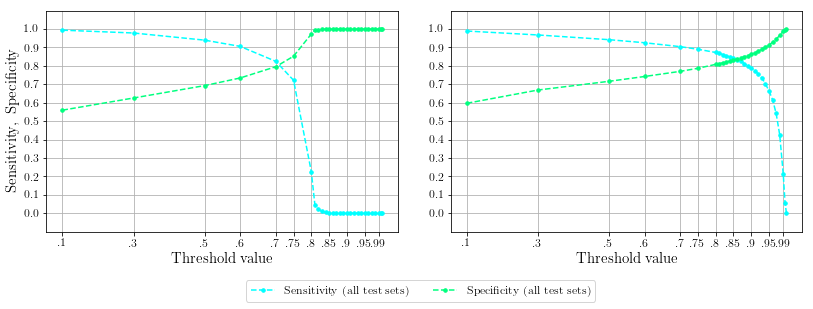

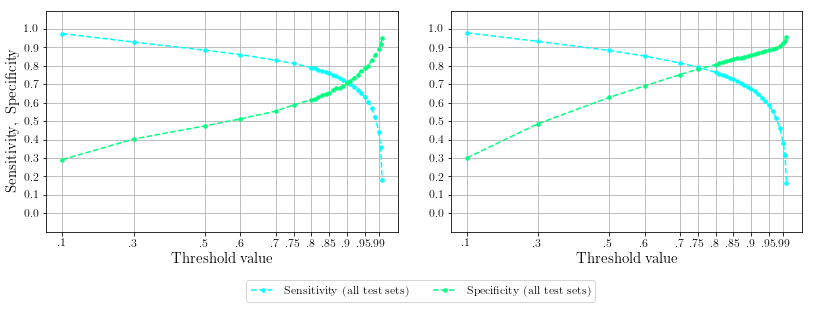

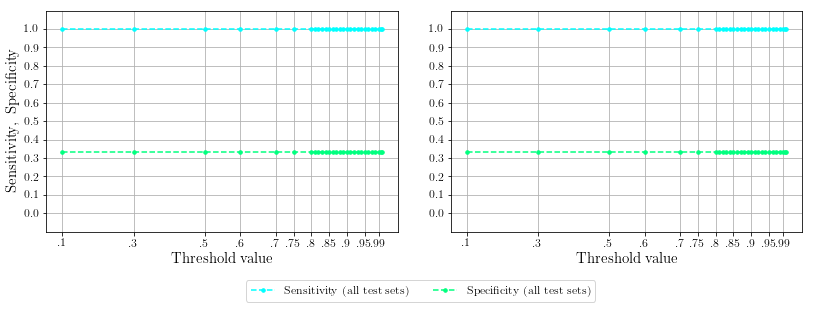

In [23]:
for i in range(3):
    #first twd
    model_name = model_paths[i][0]
    
    clean_data = []
    pseudo_data = []
    generator_data = []
    uniform_data = []
    
    thresholds_data = []
    
    for threshold in sorted(stats[model_name].keys()):
        thresholds_data.append(threshold)
        for data_type in stats[model_name][threshold].keys():
            if data_type == 'on_clean':
                clean_data.append(stats[model_name][threshold][data_type])
            if data_type == 'on_pseudo':
                pseudo_data.append(stats[model_name][threshold][data_type])
            if data_type == 'on_generator':
                generator_data.append(stats[model_name][threshold][data_type])
            elif data_type == 'on_uniform':
                uniform_data.append(stats[model_name][threshold][data_type])
    
    #get prec, rec, f1
    tpr_data_twd, tnr_data_twd = get_f1(clean_data, pseudo_data, generator_data, uniform_data)
    
    #now owd
    model_name = model_paths[i+3][0]
    
    clean_data = []
    pseudo_data = []
    generator_data = []
    uniform_data = []
    
    thresholds_data = []
    
    for threshold in sorted(stats[model_name].keys()):
        thresholds_data.append(threshold)
        for data_type in stats[model_name][threshold].keys():
            if data_type == 'on_clean':
                clean_data.append(stats[model_name][threshold][data_type])
            if data_type == 'on_pseudo':
                pseudo_data.append(stats[model_name][threshold][data_type])
            if data_type == 'on_generator':
                generator_data.append(stats[model_name][threshold][data_type])
            elif data_type == 'on_uniform':
                uniform_data.append(stats[model_name][threshold][data_type])
    
    #get prec, rec, f1
    tpr_data_owd, tnr_data_owd = get_f1(clean_data, pseudo_data, generator_data, uniform_data)
    
    
    
    
    
    
    #print(tpr_data_twd, tnr_data_twd)
    threshold_strings = []
    for threshold in thresholds_data:
        if threshold in [.1,.3,.5,.6,.7,.75,.8,.85,.9,.95,.99]:
                threshold_strings.append(r'$\mathrm{'+str(threshold)[1:]+'}$')
            
    #get tick locations
    tick_locs = []
    for thr in thresholds_data:
        if thr in [.1,.3,.5,.6,.7,.75,.8,.85,.9,.95,.99]:
            tick_locs.append(thr)
    
    
    figsize = (15,10)
    
    #plot
    plt.figure(figsize = figsize)
    
    
    markersize = 3.5
    
    plt.subplot(221)
    plt.plot(thresholds_data, tpr_data_owd,ls='--',marker='o',markersize=markersize, color = 'aqua')
    plt.plot(thresholds_data, tnr_data_owd, ls='--',marker='o',markersize=markersize, color = 'springgreen')
    plt.grid()
    plt.yticks(numpy.arange(0,1.1,0.1))
    plt.xticks(tick_locs,threshold_strings)
    #plt.xlim(xmin=0,xmax=1.1)
    plt.ylim(ymin=-0.1, ymax=1.1)
    plt.xlabel(r'$\mathrm{Threshold~value}$',fontsize=15)
    plt.ylabel(r'$\mathrm{Sensitivity,~Specificity}$',fontsize=15)
    
    
    plt.subplot(222)
    plt.plot(thresholds_data, tpr_data_twd, label=r'$\mathrm{Sensitivity~(all~test~sets)}$',ls='--',marker='o',markersize=markersize, color = 'aqua')
    plt.plot(thresholds_data, tnr_data_twd, label=r'$\mathrm{Specificity~(all~test~sets)}$', ls='--',marker='o',markersize=markersize, color = 'springgreen')
    plt.grid()
    plt.yticks(numpy.arange(0,1.1,0.1))
    plt.xticks(tick_locs,threshold_strings)
    plt.ylim(ymin=-0.1, ymax=1.1)
    plt.xlabel(r'$\mathrm{Threshold~value}$',fontsize=15)
    #plt.ylabel(r'$\mathrm{Sensitivity,~Specificity}$',fontsize=15)
    
    
    #plt.title(r'$\mathrm{'+model_name+'}$')
    
    
    plt.legend(bbox_to_anchor=(0.65, 0.16),
           ncol=4, mode=None, borderaxespad=7,fontsize='large')
    plt.subplots_adjust(left=0.2, wspace=0.15, top=0.8)
    #plt.yticks(np.arange(0.65, 1.01, 0.05))
    plt.savefig('strict4'+model_name[6:]+'.png', transparent=True,bbox_inches='tight', dpi=600)
    plt.show()
    
    
    

In [13]:
stats['ow_on_pseudorandom']

{0.1: {'on_clean': 0.9941678,
  'on_generator': 0.13591128587722778,
  'on_pseudo': 0.542827308177948,
  'on_uniform': 1.0},
 0.3: {'on_clean': 0.9787604,
  'on_generator': 0.26309359073638916,
  'on_pseudo': 0.6140320301055908,
  'on_uniform': 1.0},
 0.5: {'on_clean': 0.93993735,
  'on_generator': 0.407559335231781,
  'on_pseudo': 0.6714832782745361,
  'on_uniform': 1.0},
 0.6: {'on_clean': 0.9059889,
  'on_generator': 0.49947625398635864,
  'on_pseudo': 0.7040390074253082,
  'on_uniform': 1.0},
 0.7: {'on_clean': 0.82486075,
  'on_generator': 0.6337290406227112,
  'on_pseudo': 0.7532207518815994,
  'on_uniform': 1.0},
 0.75: {'on_clean': 0.72214484,
  'on_generator': 0.7616969347000122,
  'on_pseudo': 0.795961007475853,
  'on_uniform': 1.0},
 0.8: {'on_clean': 0.22466922,
  'on_generator': 0.9783519562333822,
  'on_pseudo': 0.941678274422884,
  'on_uniform': 1.0},
 0.81: {'on_clean': 0.046483286,
  'on_generator': 0.9958973461762071,
  'on_pseudo': 0.9873781334608793,
  'on_uniform':